# Regression models

In [1]:
# Libraries
suppressPackageStartupMessages(library(tidyverse))
library(broom)
library(survival)
suppressPackageStartupMessages(library(survminer))

# Global
options(warn = -1)

# Scripts
source("summarize.R")

# Data
load("DF.Rdata")

glimpse(DF)

Observations: 411
Variables: 23
$ registry_id            <dbl> 20060035601, 19970063502, 20040008703, 2007008…
$ pt_stage               <fct> T1, T1, T2, T1, T1, T1, Tis, T1, T2, Ta, Ta, T…
$ sp_id                  <chr> "06-S-4802", "07-S-3788", "07-S-8931", "07-S-6…
$ ck56                   <dbl> 60, 10, 90, NA, NA, 5, NA, 0, 0, 40, NA, 40, 4…
$ ck20                   <dbl> 0, 0, 0, NA, 0, 70, NA, 80, 0, 0, NA, 0, 10, N…
$ cd44                   <dbl> 70, 60, NA, NA, NA, 40, NA, 5, NA, 60, NA, NA,…
$ gata3                  <dbl> 100, 100, 100, NA, 100, 100, NA, 100, 100, 100…
$ er                     <dbl> 40, 20, NA, NA, 0, 0, 0, 0, 0, 5, NA, NA, 0, N…
$ her2                   <dbl> 0, 5, NA, NA, 60, 30, NA, 40, 60, 60, NA, 30, …
$ uroplakin              <dbl> 5, 20, NA, NA, NA, 0, NA, 10, NA, 0, NA, NA, 0…
$ sex                    <fct> Male, Male, Male, Male, Male, Male, Female, Ma…
$ death                  <fct> Dead, Alive, Dead, Alive, Alive, Alive, Alive,…
$ progression_stage_

In [2]:
# A function to define which statistics (v.g., median, max value) will be used for summarizing biomarkers expression
# If needed, changing this function will update the approach for the entire analysis
summarize_biomarker <- function(x) { mean(x, na.rm = TRUE) }

# Tidying up the data and summarizing expression
OUTCOME <- DF %>% 
    group_by(sp_id) %>% 
    summarize(
        ck56 = summarize_biomarker(ck56),
        cd44 = summarize_biomarker(cd44),
        ck20 = summarize_biomarker(ck20),
        er = summarize_biomarker(er),
        her2 = summarize_biomarker(her2),
        gata3 = summarize_biomarker(gata3),
        uroplakin = summarize_biomarker(uroplakin),
        pt_stage = unique(pt_stage),
        fu_mo = unique(fu_mo),
        recurrence_next = unique(recurrence_next),
        recurrence_any = unique(recurrence_any),
        progression_grade_next = unique(progression_grade_next),
        progression_grade_any = unique(progression_grade_any),
        progression_stage_next = unique(progression_stage_next),
        progression_stage_any = unique(progression_stage_any)
    ) %>% 
    mutate(
        pt = ifelse(
          pt_stage == "Tis" | pt_stage == "Ta",
          "Low pT stage (<pT1)", "High pT stage (pT1-pT2)"
        ),
        pt = fct_relevel(pt, "Low pT stage (<pT1)"),
        ck56_level = ifelse(
          ck56 > summarize_biomarker(ck56),
          "High CK5/6 expression", "Low CK5/6 expression"
        ),
        ck56_level = fct_relevel(ck56_level, "Low CK5/6 expression"),
        cd44_level = ifelse(
          cd44 > summarize_biomarker(cd44),
          "High CD44 expression", "Low CD44 expression"
        ),
        cd44_level = fct_relevel(cd44_level, "Low CD44 expression"),
        ck20_level = ifelse(
          ck20 > summarize_biomarker(ck20),
          "High CK20 expression", "Low CK20 expression"
        ),
        ck20_level = fct_relevel(ck20_level, "Low CK20 expression"),
        er_level = ifelse(
          er > summarize_biomarker(er),
          "High ER expression", "Low ER expression"
        ),
        er_level = fct_relevel(er_level, "Low CK20 expression"),
        her2_level = ifelse(
          her2 > summarize_biomarker(her2),
          "High HER2 expression", "Low HER2 expression"
        ),
        her2_level = fct_relevel(her2_level, "Low HER2 expression"),
        gata3_level = ifelse(
          gata3 > summarize_biomarker(gata3),
          "High GATA3 expression", "Low GATA3 expression"
        ),
        gata3_level = fct_relevel(gata3_level, "Low GATA3 expression"),
        uroplakin_level = ifelse(
          uroplakin > summarize_biomarker(uroplakin),
          "High Uroplakin expression", "Low Uroplakin expression"
        ),
        uroplakin_level = fct_relevel(uroplakin_level, "Low Uroplakin expression")
    )

glimpse(OUTCOME)

Observations: 128
Variables: 24
$ sp_id                  <chr> "01-S-10015", "01-S-7500", "01-S-9347", "02-S-…
$ ck56                   <dbl> 5.000000, 3.333333, 10.000000, 11.000000, 15.0…
$ cd44                   <dbl> 30.000000, 15.000000, 43.333333, 26.000000, 38…
$ ck20                   <dbl> 10.000000, 23.333333, 30.000000, 25.000000, 76…
$ er                     <dbl> 0.0000000, 0.0000000, 0.0000000, 0.0000000, 0.…
$ her2                   <dbl> 36.666667, 0.000000, 18.333333, 1.666667, 50.0…
$ gata3                  <dbl> 100.00000, 100.00000, 100.00000, 100.00000, 10…
$ uroplakin              <dbl> 0.0000000, 0.0000000, 6.6666667, 6.6666667, 21…
$ pt_stage               <fct> Ta, Ta, Ta, T1, T1, T1, T1, T1, Ta, T1, Ta, Ta…
$ fu_mo                  <dbl> 85.2, 4.5, 85.2, 57.9, 57.9, 31.3, 31.3, 3.9, …
$ recurrence_next        <fct> No tumor recurrence, Tumor recurrence, Tumor r…
$ recurrence_any         <fct> Tumor recurrence, Tumor recurrence, Tumor recu…
$ progression_grade_

## CK5/6

In [3]:
OUTCOME <- OUTCOME %>% 
  mutate(biomarker_level = ck56_level)
OUTCOME %>% summarize_fct(biomarker_level)

# A tibble: 3 x 3
  Levels                    N  Freq
  <fct>                 <int> <dbl>
1 Low CK5/6 expression     70  54.7
2 High CK5/6 expression    47  36.7
3 <NA>                     11   8.6


### Tumor recurrence at next biopsy
#### Unadjusted

In [4]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.43      0.41      1.04   0.298  1.54     0.68      3.46


#### Adjusted by pT stage (low vs high)

In [5]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.25      0.43     0.580   0.563  1.28     0.55      2.99
2 ptHigh pT stage…    -0.04      0.44    -0.09    0.929  0.96     0.4       2.28


### Tumor recurrence at any biopsy
#### Unadjusted

In [6]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.44      0.66      0.66   0.510  1.55     0.41      5.88


#### Adjusted by pT stage (low vs high)

In [7]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.23      0.79     0.290  0.774   1.26     0.24      5.79
2 ptHigh pT stage…     1.31      0.78     1.68   0.0929  3.71     0.83     19.6 


### Tumor grade progression at next biopsy
#### Unadjusted

In [8]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.02      0.94      0.03   0.979  1.02     0.16      8.04


#### Adjusted by pT stage (low vs high)

In [9]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term           estimate std.error statistic p.value      or conf.low conf.high
  <chr>             <dbl>     <dbl>     <dbl>   <dbl>   <dbl>    <dbl>     <dbl>
1 biomarker_lev…     0.24      0.95      0.25   0.799  1.27e0      0.2      10.2
2 ptHigh pT sta…    18.1    2913.        0.01   0.995  7.33e7      0        NA  


### Tumor grade progression at any biopsy
#### Unadjusted

In [10]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.07      0.62     -0.11   0.911  0.93     0.28      3.34


#### Adjusted by pT stage (low vs high)

In [11]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.26      0.67      0.39   0.698  1.3      0.36      5.32
2 ptHigh pT stage…     0.98      0.82      1.19   0.233  2.66     0.63     18.3 


### Tumor stage progression at next biopsy
#### Unadjusted

In [12]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.78      1.14     -1.57   0.117  0.17     0.01      1.19


#### Adjusted by pT stage (low vs high)

In [13]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -2.21      1.18     -1.88  0.0606  0.11     0.01      0.84
2 ptHigh pT stage…    -1.52      0.99     -1.54  0.123   0.22     0.03      1.49


### Tumor stage progression at any biopsy
#### Unadjusted

In [14]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.17      0.54     -0.31   0.753  0.84    0.290      2.53


#### Adjusted by pT stage (low vs high)

In [15]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.12      0.68     -1.65 9.96e-2  0.33     0.08      1.21
2 ptHigh pT stage…    -3.36      0.85     -3.97 7.15e-5  0.03     0         0.15


## CD44

In [16]:
OUTCOME <- OUTCOME %>% 
  mutate(biomarker_level = cd44_level)
OUTCOME %>% summarize_fct(biomarker_level)

# A tibble: 3 x 3
  Levels                   N  Freq
  <fct>                <int> <dbl>
1 Low CD44 expression     57  44.5
2 High CD44 expression    57  44.5
3 <NA>                    14  10.9


### Tumor recurrence at next biopsy
#### Unadjusted

In [17]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.92      0.42      2.16  0.0308  2.51      1.1      5.85


#### Adjusted by pT stage (low vs high)

In [18]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.8       0.44     1.79   0.0734  2.23     0.94      5.4 
2 ptHigh pT stage…    -0.13      0.47    -0.290  0.773   0.88     0.34      2.17


### Tumor recurrence at any biopsy
#### Unadjusted

In [19]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.92      0.72      1.29   0.198  2.51     0.66      12.2


#### Adjusted by pT stage (low vs high)

In [20]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.87      0.78      1.1   0.270   2.39     0.53      12.8
2 ptHigh pT stage…     1.44      0.78      1.84  0.0657  4.22     0.94      22.4


### Tumor grade progression at next biopsy
#### Unadjusted

In [21]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.69      1.24      0.56   0.576  1.99     0.19      43.8


#### Adjusted by pT stage (low vs high)

In [22]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term           estimate std.error statistic p.value      or conf.low conf.high
  <chr>             <dbl>     <dbl>     <dbl>   <dbl>   <dbl>    <dbl>     <dbl>
1 biomarker_lev…     0.89      1.25      0.71   0.475  2.44e0     0.22      54.3
2 ptHigh pT sta…    17.7    2966.        0.01   0.995  4.82e7     0         NA  


### Tumor grade progression at any biopsy
#### Unadjusted

In [23]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.44      0.67     -0.66   0.511  0.64     0.16      2.38


#### Adjusted by pT stage (low vs high)

In [24]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.15      0.71     -0.2    0.838  0.86     0.2       3.53
2 ptHigh pT stage…     1.48      1.09      1.36   0.173  4.39     0.75     83.7 


### Tumor stage progression at next biopsy
#### Unadjusted

In [25]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.45      0.94      0.48   0.632  1.57     0.25      12.3


#### Adjusted by pT stage (low vs high)

In [26]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.24      0.95      0.25   0.804  1.27     0.19     10.2 
2 ptHigh pT stage…    -1.05      0.95     -1.1    0.270  0.35     0.04      2.26


### Tumor stage progression at any biopsy
#### Unadjusted

In [27]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.79     0.580      1.36   0.173   2.2     0.73      7.54


#### Adjusted by pT stage (low vs high)

In [28]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.41      0.65      0.64 5.25e-1  1.51     0.43      5.73
2 ptHigh pT stage…    -2.89      0.8      -3.62 3.00e-4  0.06     0.01      0.22


## CK20

In [29]:
OUTCOME <- OUTCOME %>% 
  mutate(biomarker_level = ck20_level)
OUTCOME %>% summarize_fct(biomarker_level)

# A tibble: 3 x 3
  Levels                   N  Freq
  <fct>                <int> <dbl>
1 Low CK20 expression     67  52.3
2 High CK20 expression    49  38.3
3 <NA>                    12   9.4


### Tumor recurrence at next biopsy
#### Unadjusted

In [30]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.15      0.42     -0.35   0.726  0.86     0.38      1.95


#### Adjusted by pT stage (low vs high)

In [31]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.02      0.42     -0.04   0.965  0.98     0.42      2.25
2 ptHigh pT stage…    -0.04      0.44     -0.09   0.925  0.96     0.4       2.24


### Tumor recurrence at any biopsy
#### Unadjusted

In [32]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…   -0.580      0.72     -0.81   0.418  0.56     0.12      2.13


#### Adjusted by pT stage (low vs high)

In [33]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     -0.3      0.77     -0.39  0.699   0.74     0.14      3.26
2 ptHigh pT stage…      1.3      0.76      1.71  0.0878  3.67     0.85     18.8 


### Tumor grade progression at next biopsy
#### Unadjusted

In [34]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.81      0.94     -0.87   0.386  0.44     0.06       2.8


#### Adjusted by pT stage (low vs high)

In [35]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term          estimate std.error statistic p.value       or conf.low conf.high
  <chr>            <dbl>     <dbl>     <dbl>   <dbl>    <dbl>    <dbl>     <dbl>
1 biomarker_le…    -0.77      0.95     -0.81   0.417  4.60e-1     0.06      2.99
2 ptHigh pT st…    18.0    2926.        0.01   0.995  6.90e+7     0        NA   


### Tumor grade progression at any biopsy
#### Unadjusted

In [36]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.35      0.61    -0.570   0.567   0.7     0.21      2.39


#### Adjusted by pT stage (low vs high)

In [37]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.52      0.64     -0.81   0.418  0.59     0.16      2.11
2 ptHigh pT stage…     0.91      0.81      1.13   0.260  2.48     0.6      17.0 


### Tumor stage progression at next biopsy
#### Unadjusted

In [38]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…      0.7      1.17       0.6   0.550  2.01     0.25      41.6


#### Adjusted by pT stage (low vs high)

In [39]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.76      1.18      0.65   0.517  2.14     0.26     44.3 
2 ptHigh pT stage…    -0.67      1.03     -0.65   0.515  0.51     0.06      4.45


### Tumor stage progression at any biopsy
#### Unadjusted

In [40]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.79      0.62      1.28   0.199   2.2      0.7       8.4


#### Adjusted by pT stage (low vs high)

In [41]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     1.11      0.68      1.62 1.05e-1  3.03     0.84     12.8 
2 ptHigh pT stage…    -3.05      0.81     -3.77 1.61e-4  0.05     0.01      0.19


## ER

In [42]:
OUTCOME <- OUTCOME %>% 
  mutate(biomarker_level = er_level)
OUTCOME %>% summarize_fct(biomarker_level)

# A tibble: 3 x 3
  Levels                 N  Freq
  <fct>              <int> <dbl>
1 High ER expression    19  14.8
2 Low ER expression     99  77.3
3 <NA>                  10   7.8


### Tumor recurrence at next biopsy
#### Unadjusted

In [43]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.12      0.54     -0.22   0.828  0.89     0.31      2.66


#### Adjusted by pT stage (low vs high)

In [44]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.14      0.6      0.23    0.814  1.15     0.37      3.99
2 ptHigh pT stage…    -0.13      0.44    -0.290   0.770  0.88     0.36      2.07


### Tumor recurrence at any biopsy
#### Unadjusted

In [45]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.42       0.7     -2.02  0.0435  0.24     0.06      1.04


#### Adjusted by pT stage (low vs high)

In [46]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.3       0.8      -1.62   0.106  0.27     0.06      1.49
2 ptHigh pT stage…     1.25      0.77      1.62   0.105  3.49     0.79     18.1 


### Tumor grade progression at next biopsy
#### Unadjusted

In [47]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -16.7     2535.     -0.01   0.995     0       NA  8.74e112


#### Adjusted by pT stage (low vs high)

In [48]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term           estimate std.error statistic p.value      or conf.low conf.high
  <chr>             <dbl>     <dbl>     <dbl>   <dbl>   <dbl>    <dbl>     <dbl>
1 biomarker_lev…    -17.4     4057.      0      0.997  0.           NA  4.83e183
2 ptHigh pT sta…     17.9     2854.      0.01   0.995  6.06e7        0 NA       


### Tumor grade progression at any biopsy
#### Unadjusted

In [49]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.16      0.83       0.2   0.844  1.17     0.17      5.09


#### Adjusted by pT stage (low vs high)

In [50]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.39      1.1      -0.36   0.721  0.68     0.03      4.12
2 ptHigh pT stage…     1.59      1.07      1.48   0.140  4.9      0.87     92.0 


### Tumor stage progression at next biopsy
#### Unadjusted

In [51]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -16.8     2688.     -0.01   0.995     0       NA  1.52e120


#### Adjusted by pT stage (low vs high)

In [52]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…   -16.9    2806.       -0.01   0.995   0      NA     2.34e125
2 ptHigh pT stage…    -1.19      0.94     -1.26   0.206   0.3     0.04  1.94e  0


### Tumor stage progression at any biopsy
#### Unadjusted

In [53]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.25       0.8     -0.31   0.755  0.78     0.12      3.17


#### Adjusted by pT stage (low vs high)

In [54]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.47      0.88     -0.53 5.94e-1  0.63     0.08      3.08
2 ptHigh pT stage…    -2.99      0.8      -3.75 1.79e-4  0.05     0.01      0.2 


## HER2

In [55]:
OUTCOME <- OUTCOME %>% 
  mutate(biomarker_level = her2_level)
OUTCOME %>% summarize_fct(biomarker_level)

# A tibble: 3 x 3
  Levels                   N  Freq
  <fct>                <int> <dbl>
1 Low HER2 expression     64  50  
2 High HER2 expression    53  41.4
3 <NA>                    11   8.6


### Tumor recurrence at next biopsy
#### Unadjusted

In [56]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.31      0.41     -0.77   0.444  0.73     0.33      1.62


#### Adjusted by pT stage (low vs high)

In [57]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.12      0.42     -0.27   0.784  0.89     0.39      2.04
2 ptHigh pT stage…    -0.09      0.44     -0.21   0.834  0.91     0.38      2.15


### Tumor recurrence at any biopsy
#### Unadjusted

In [58]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.29      0.81     -1.59   0.112  0.28     0.04      1.16


#### Adjusted by pT stage (low vs high)

In [59]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.35      0.87     -1.56  0.120   0.26     0.04      1.25
2 ptHigh pT stage…     1.51      0.79      1.92  0.0548  4.53     1        24.3 


### Tumor grade progression at next biopsy
#### Unadjusted

In [60]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.65      1.14     -1.45   0.147  0.19     0.01      1.36


#### Adjusted by pT stage (low vs high)

In [61]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term          estimate std.error statistic p.value       or conf.low conf.high
  <chr>            <dbl>     <dbl>     <dbl>   <dbl>    <dbl>    <dbl>     <dbl>
1 biomarker_le…    -1.93      1.15     -1.68  0.0927  1.50e-1     0.01      1.05
2 ptHigh pT st…    18.4    2796.        0.01  0.995   9.32e+7     0        NA   


### Tumor grade progression at any biopsy
#### Unadjusted

In [62]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.43       0.7     -2.05  0.0404  0.24     0.05      0.86


#### Adjusted by pT stage (low vs high)

In [63]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.99      0.82     -2.43  0.0153  0.14     0.02     0.580
2 ptHigh pT stage…     1.3       0.83      1.57  0.118   3.67     0.84    25.8  


### Tumor stage progression at next biopsy
#### Unadjusted

In [64]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.63      0.94     -0.68   0.498  0.53     0.07      3.34


#### Adjusted by pT stage (low vs high)

In [65]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.41      0.95     -0.43   0.668  0.66     0.08      4.34
2 ptHigh pT stage…    -0.99      0.95     -1.04   0.298  0.37     0.05      2.41


### Tumor stage progression at any biopsy
#### Unadjusted

In [66]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.51      0.54     -0.94   0.347   0.6      0.2      1.74


#### Adjusted by pT stage (low vs high)

In [67]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.03      0.62      0.04 9.67e-1  1.03     0.3       3.47
2 ptHigh pT stage…    -3.01      0.8      -3.76 1.67e-4  0.05     0.01      0.2 


## GATA3

In [68]:
OUTCOME <- OUTCOME %>% 
  mutate(biomarker_level = gata3_level)
OUTCOME %>% summarize_fct(biomarker_level)

# A tibble: 3 x 3
  Levels                    N  Freq
  <fct>                 <int> <dbl>
1 Low GATA3 expression      9   7  
2 High GATA3 expression   108  84.4
3 <NA>                     11   8.6


### Tumor recurrence at next biopsy
#### Unadjusted

In [69]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.08      0.76       0.1   0.918  1.08     0.25      5.53


#### Adjusted by pT stage (low vs high)

In [70]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.09      0.77     -0.11   0.911  0.91     0.21      4.79
2 ptHigh pT stage…    -0.17      0.45     -0.39   0.698  0.84     0.34      2   


### Tumor recurrence at any biopsy
#### Unadjusted

In [71]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.32      1.12    -0.290   0.775  0.73     0.11      14.3


#### Adjusted by pT stage (low vs high)

In [72]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.26      1.16     -0.23  0.821   0.77     0.11      15.8
2 ptHigh pT stage…     1.27      0.77      1.65  0.0979  3.56     0.81      18.4


### Tumor grade progression at next biopsy
#### Unadjusted

In [73]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -15.6     2174.     -0.01   0.994     0       NA   2.77e96


#### Adjusted by pT stage (low vs high)

In [74]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term            estimate std.error statistic p.value     or conf.low conf.high
  <chr>              <dbl>     <dbl>     <dbl>   <dbl>  <dbl>    <dbl>     <dbl>
1 biomarker_leve…    -17.1     5265.      0      0.997 0.           NA  3.15e251
2 ptHigh pT stag…     17.9     2886.      0.01   0.995 6.18e7        0 NA       


### Tumor grade progression at any biopsy
#### Unadjusted

In [75]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -16.4     2174.     -0.01   0.994     0       NA   1.04e68


#### Adjusted by pT stage (low vs high)

In [76]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…   -16.0    2095.       -0.01   0.994  0       NA      1.92e88
2 ptHigh pT stage…     1.54      1.08      1.43   0.154  4.66     0.82   8.76e 1


### Tumor stage progression at next biopsy
#### Unadjusted

In [77]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     1.17      1.18      0.99   0.324  3.22     0.15      25.8


#### Adjusted by pT stage (low vs high)

In [78]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.84      1.22      0.69   0.488  2.32     0.11     20.0 
2 ptHigh pT stage…    -0.99      0.96     -1.03   0.302  0.37     0.05      2.48


### Tumor stage progression at any biopsy
#### Unadjusted

In [79]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.74      0.85      0.86   0.389   2.1    0.290      9.81


#### Adjusted by pT stage (low vs high)

In [80]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.17      0.94      0.18 8.60e-1  1.19     0.15      6.97
2 ptHigh pT stage…    -2.93      0.8      -3.68 2.37e-4  0.05     0.01      0.21


## Uroplakin

In [81]:
OUTCOME <- OUTCOME %>% 
  mutate(biomarker_level = uroplakin_level)
OUTCOME %>% summarize_fct(biomarker_level)

# A tibble: 3 x 3
  Levels                        N  Freq
  <fct>                     <int> <dbl>
1 Low Uroplakin expression     83  64.8
2 High Uroplakin expression    32  25  
3 <NA>                         13  10.2


### Tumor recurrence at next biopsy
#### Unadjusted

In [82]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.61      0.46     -1.31   0.191  0.54     0.21      1.32


#### Adjusted by pT stage (low vs high)

In [83]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.44      0.47     -0.92   0.358  0.64     0.25      1.61
2 ptHigh pT stage…    -0.19      0.46     -0.43   0.671  0.83     0.33      1.99


### Tumor recurrence at any biopsy
#### Unadjusted

In [84]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.12      0.72      0.16   0.873  1.13     0.23      4.34


#### Adjusted by pT stage (low vs high)

In [85]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.24      0.78      0.3   0.761   1.27     0.24      5.69
2 ptHigh pT stage…     1.28      0.77      1.66  0.0968  3.6      0.82     18.5 


### Tumor grade progression at next biopsy
#### Unadjusted

In [86]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.35      0.94     -1.44   0.151  0.26     0.03      1.64


#### Adjusted by pT stage (low vs high)

In [87]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term           estimate std.error statistic p.value      or conf.low conf.high
  <chr>             <dbl>     <dbl>     <dbl>   <dbl>   <dbl>    <dbl>     <dbl>
1 biomarker_lev…    -1.62      0.96     -1.68  0.0930 2.00e-1     0.02      1.31
2 ptHigh pT sta…    18.3    2876.        0.01  0.995  8.77e+7     0        NA   


### Tumor grade progression at any biopsy
#### Unadjusted

In [88]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.03      0.71      0.04   0.966  1.03     0.28      4.95


#### Adjusted by pT stage (low vs high)

In [89]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.25      0.74     -0.33   0.739  0.78     0.19       3.9
2 ptHigh pT stage…     1.64      1.08      1.52   0.129  5.16     0.9       97.9


### Tumor stage progression at next biopsy
#### Unadjusted

In [90]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.48      0.94     -0.51   0.608  0.62      0.1      4.88


#### Adjusted by pT stage (low vs high)

In [91]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.27      0.96     -0.28   0.778  0.76     0.12      6.2 
2 ptHigh pT stage…    -1.1       0.95     -1.16   0.248  0.33     0.04      2.15


### Tumor stage progression at any biopsy
#### Unadjusted

In [92]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     -0.3      0.59     -0.51   0.611  0.74     0.24      2.55


#### Adjusted by pT stage (low vs high)

In [93]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.18      0.66      0.26 7.91e-1  1.2      0.34      4.66
2 ptHigh pT stage…    -3         0.8      -3.74 1.87e-4  0.05     0.01      0.2 


## Summary plot
Expression of ER and GATA3 were excluded from analysis, considering that most tumor cells lacked ER expression and most tumor cells were GATA3 positive.

In [94]:
# A function to estimate odds ratios using binomial logistic regression
OR_tbl <- function(data, formula, marker, outcome, ...) {
  
  mdl <- glm(as.formula(formula), data = data, family = "binomial", ...)
  mdl_coef <- tidy(mdl) %>% 
    mutate(
      estimate = round(estimate, digits = 2),
      std.error = round(std.error, digits = 2),
      statistic = round(statistic, digits = 2),
      or = round(exp(estimate), digits = 2)
    )
  mdl_confint <- exp(confint_tidy(mdl)) %>% round(digits = 2)
  mdl_tbl <- bind_cols(mdl_coef, mdl_confint) %>% 
    select(or, conf.low, conf.high) %>% 
    mutate(
        marker = paste(marker),
        outcome = paste(outcome)
    )
  
  return(mdl_tbl[2 , ])

}

### Tumor recurrence at next biopsy

In [95]:
outcome_str <- "Recurrence at next biopsy"
outcome_ck56 <- OUTCOME %>% OR_tbl(recurrence_next ~ ck56 + pt, "CK5/6", outcome_str)
outcome_ck20 <- OUTCOME %>% OR_tbl(recurrence_next ~ ck20 + pt, "CK20", outcome_str)
outcome_cd44 <- OUTCOME %>% OR_tbl(recurrence_next ~ cd44 + pt, "CD44", outcome_str)
outcome_her2 <- OUTCOME %>% OR_tbl(recurrence_next ~ her2 + pt, "Her2", outcome_str)
outcome_uroplk <- OUTCOME %>% OR_tbl(recurrence_next ~ uroplakin + pt, "Uroplakin", outcome_str)

recurrence_next_marker <- bind_rows(
    outcome_uroplk, outcome_her2, outcome_ck20, outcome_cd44, outcome_ck56
)

print(recurrence_next_marker)

# A tibble: 5 x 5
     or conf.low conf.high marker    outcome                  
  <dbl>    <dbl>     <dbl> <chr>     <chr>                    
1  1        0.98      1.01 Uroplakin Recurrence at next biopsy
2  1        0.98      1.01 Her2      Recurrence at next biopsy
3  1        0.99      1.01 CK20      Recurrence at next biopsy
4  1.01     1         1.03 CD44      Recurrence at next biopsy
5  1        0.99      1.02 CK5/6     Recurrence at next biopsy


### Tumor recurrence at any biopsy

In [96]:
outcome_str <- "Recurrence at any biopsy"
outcome_ck56 <- OUTCOME %>% OR_tbl(recurrence_any ~ ck56 + pt, "CK5/6", outcome_str)
outcome_ck20 <- OUTCOME %>% OR_tbl(recurrence_any ~ ck20 + pt, "CK20", outcome_str)
outcome_cd44 <- OUTCOME %>% OR_tbl(recurrence_any ~ cd44 + pt, "CD44", outcome_str)
outcome_her2 <- OUTCOME %>% OR_tbl(recurrence_any ~ her2 + pt, "Her2", outcome_str)
outcome_uroplk <- OUTCOME %>% OR_tbl(recurrence_any ~ uroplakin + pt, "Uroplakin", outcome_str)

recurrence_any_marker <- bind_rows(
    outcome_uroplk, outcome_her2, outcome_ck20, outcome_cd44, outcome_ck56
)

print(recurrence_any_marker)

# A tibble: 5 x 5
     or conf.low conf.high marker    outcome                 
  <dbl>    <dbl>     <dbl> <chr>     <chr>                   
1  0.98     0.92      1.01 Uroplakin Recurrence at any biopsy
2  0.97     0.94      1    Her2      Recurrence at any biopsy
3  0.99     0.96      1.01 CK20      Recurrence at any biopsy
4  1.01     0.99      1.04 CD44      Recurrence at any biopsy
5  1        0.96      1.03 CK5/6     Recurrence at any biopsy


### Tumor stage progression at next biopsy

In [97]:
outcome_str <- "Tumor stage progression at next biopsy"
outcome_ck56 <- OUTCOME %>% OR_tbl(progression_stage_next ~ ck56 + pt, "CK5/6", outcome_str)
outcome_ck20 <- OUTCOME %>% OR_tbl(progression_stage_next ~ ck20 + pt, "CK20", outcome_str)
outcome_cd44 <- OUTCOME %>% OR_tbl(progression_stage_next ~ cd44 + pt, "CD44", outcome_str)
outcome_her2 <- OUTCOME %>% OR_tbl(progression_stage_next ~ her2 + pt, "Her2", outcome_str)
outcome_uroplk <- OUTCOME %>% OR_tbl(progression_stage_next ~ uroplakin + pt, "Uroplakin", outcome_str)

progression_stage_next_marker <- bind_rows(
    outcome_uroplk, outcome_her2, outcome_ck20, outcome_cd44, outcome_ck56
)

print(progression_stage_next_marker)

# A tibble: 5 x 5
     or conf.low conf.high marker    outcome                               
  <dbl>    <dbl>     <dbl> <chr>     <chr>                                 
1  1.01     0.98      1.09 Uroplakin Tumor stage progression at next biopsy
2  1        0.97      1.03 Her2      Tumor stage progression at next biopsy
3  1.01     0.98      1.05 CK20      Tumor stage progression at next biopsy
4  1.01     0.98      1.05 CD44      Tumor stage progression at next biopsy
5  0.94     0.9       0.98 CK5/6     Tumor stage progression at next biopsy


### Tumor stage progression at any biopsy

In [98]:
outcome_str <- "Tumor stage progression at any biopsy"
outcome_ck56 <- OUTCOME %>% OR_tbl(progression_stage_any ~ ck56 + pt, "CK5/6", outcome_str)
outcome_ck20 <- OUTCOME %>% OR_tbl(progression_stage_any ~ ck20 + pt, "CK20", outcome_str)
outcome_cd44 <- OUTCOME %>% OR_tbl(progression_stage_any ~ cd44 + pt, "CD44", outcome_str)
outcome_her2 <- OUTCOME %>% OR_tbl(progression_stage_any ~ her2 + pt, "Her2", outcome_str)
outcome_uroplk <- OUTCOME %>% OR_tbl(progression_stage_any ~ uroplakin + pt, "Uroplakin", outcome_str)

progression_stage_any_marker <- bind_rows(
    outcome_uroplk, outcome_her2, outcome_ck20, outcome_cd44, outcome_ck56
)

print(progression_stage_any_marker)

# A tibble: 5 x 5
     or conf.low conf.high marker    outcome                              
  <dbl>    <dbl>     <dbl> <chr>     <chr>                                
1  1.02     0.99      1.06 Uroplakin Tumor stage progression at any biopsy
2  1        0.98      1.02 Her2      Tumor stage progression at any biopsy
3  1.01     0.99      1.04 CK20      Tumor stage progression at any biopsy
4  1.01     0.99      1.04 CD44      Tumor stage progression at any biopsy
5  0.97     0.94      0.99 CK5/6     Tumor stage progression at any biopsy


### Tumor grade progression at next biopsy

In [99]:
outcome_str <- "Tumor grade progression at next biopsy"
outcome_ck56 <- OUTCOME %>% OR_tbl(progression_grade_next ~ ck56 + pt, "CK5/6", outcome_str)
outcome_ck20 <- OUTCOME %>% OR_tbl(progression_grade_next ~ ck20 + pt, "CK20", outcome_str)
outcome_cd44 <- OUTCOME %>% OR_tbl(progression_grade_next ~ cd44 + pt, "CD44", outcome_str)
outcome_her2 <- OUTCOME %>% OR_tbl(progression_grade_next ~ her2 + pt, "Her2", outcome_str)
outcome_uroplk <- OUTCOME %>% OR_tbl(progression_grade_next ~ uroplakin + pt, "Uroplakin", outcome_str)

progression_grade_next_marker <- bind_rows(
    outcome_uroplk, outcome_her2, outcome_ck20, outcome_cd44, outcome_ck56
)

print(progression_grade_next_marker)

# A tibble: 5 x 5
     or conf.low conf.high marker    outcome                               
  <dbl>    <dbl>     <dbl> <chr>     <chr>                                 
1  0.97     0.94      1.02 Uroplakin Tumor grade progression at next biopsy
2  0.97     0.94      1    Her2      Tumor grade progression at next biopsy
3  0.99     0.96      1.02 CK20      Tumor grade progression at next biopsy
4  1.02     0.98      1.06 CD44      Tumor grade progression at next biopsy
5  1        0.97      1.04 CK5/6     Tumor grade progression at next biopsy


### Tumor grade progression at any biopsy

In [100]:
outcome_str <- "Tumor grade progression at any biopsy"
outcome_ck56 <- OUTCOME %>% OR_tbl(progression_grade_any ~ ck56 + pt, "CK5/6", outcome_str)
outcome_ck20 <- OUTCOME %>% OR_tbl(progression_grade_any ~ ck20 + pt, "CK20", outcome_str)
outcome_cd44 <- OUTCOME %>% OR_tbl(progression_grade_any ~ cd44 + pt, "CD44", outcome_str)
outcome_her2 <- OUTCOME %>% OR_tbl(progression_grade_any ~ her2 + pt, "Her2", outcome_str)
outcome_uroplk <- OUTCOME %>% OR_tbl(progression_grade_any ~ uroplakin + pt, "Uroplakin", outcome_str)

progression_grade_any_marker <- bind_rows(
    outcome_uroplk, outcome_her2, outcome_ck20, outcome_cd44, outcome_ck56
)

print(progression_grade_any_marker)

# A tibble: 5 x 5
     or conf.low conf.high marker    outcome                              
  <dbl>    <dbl>     <dbl> <chr>     <chr>                                
1  1        0.97      1.05 Uroplakin Tumor grade progression at any biopsy
2  0.98     0.95      1    Her2      Tumor grade progression at any biopsy
3  0.99     0.97      1.01 CK20      Tumor grade progression at any biopsy
4  1        0.98      1.02 CD44      Tumor grade progression at any biopsy
5  1.01     0.98      1.04 CK5/6     Tumor grade progression at any biopsy


### Final table

In [101]:
outcome_marker <- bind_rows(
  recurrence_next_marker,
  recurrence_any_marker,
  progression_grade_next_marker,
  progression_grade_any_marker,
  progression_stage_next_marker,
  progression_stage_any_marker
)

print(outcome_marker)

# A tibble: 30 x 5
      or conf.low conf.high marker    outcome                  
   <dbl>    <dbl>     <dbl> <chr>     <chr>                    
 1  1        0.98      1.01 Uroplakin Recurrence at next biopsy
 2  1        0.98      1.01 Her2      Recurrence at next biopsy
 3  1        0.99      1.01 CK20      Recurrence at next biopsy
 4  1.01     1         1.03 CD44      Recurrence at next biopsy
 5  1        0.99      1.02 CK5/6     Recurrence at next biopsy
 6  0.98     0.92      1.01 Uroplakin Recurrence at any biopsy 
 7  0.97     0.94      1    Her2      Recurrence at any biopsy 
 8  0.99     0.96      1.01 CK20      Recurrence at any biopsy 
 9  1.01     0.99      1.04 CD44      Recurrence at any biopsy 
10  1        0.96      1.03 CK5/6     Recurrence at any biopsy 
# … with 20 more rows


### Plot
Forest plots of biomarkers by outcome. Odds ratios (dots) with 95% confidence intervals (error bars) of expression levels and outcome. The dashed line corresponds to an odds ratio of 1. Odds ratios were adjusted by pT stage

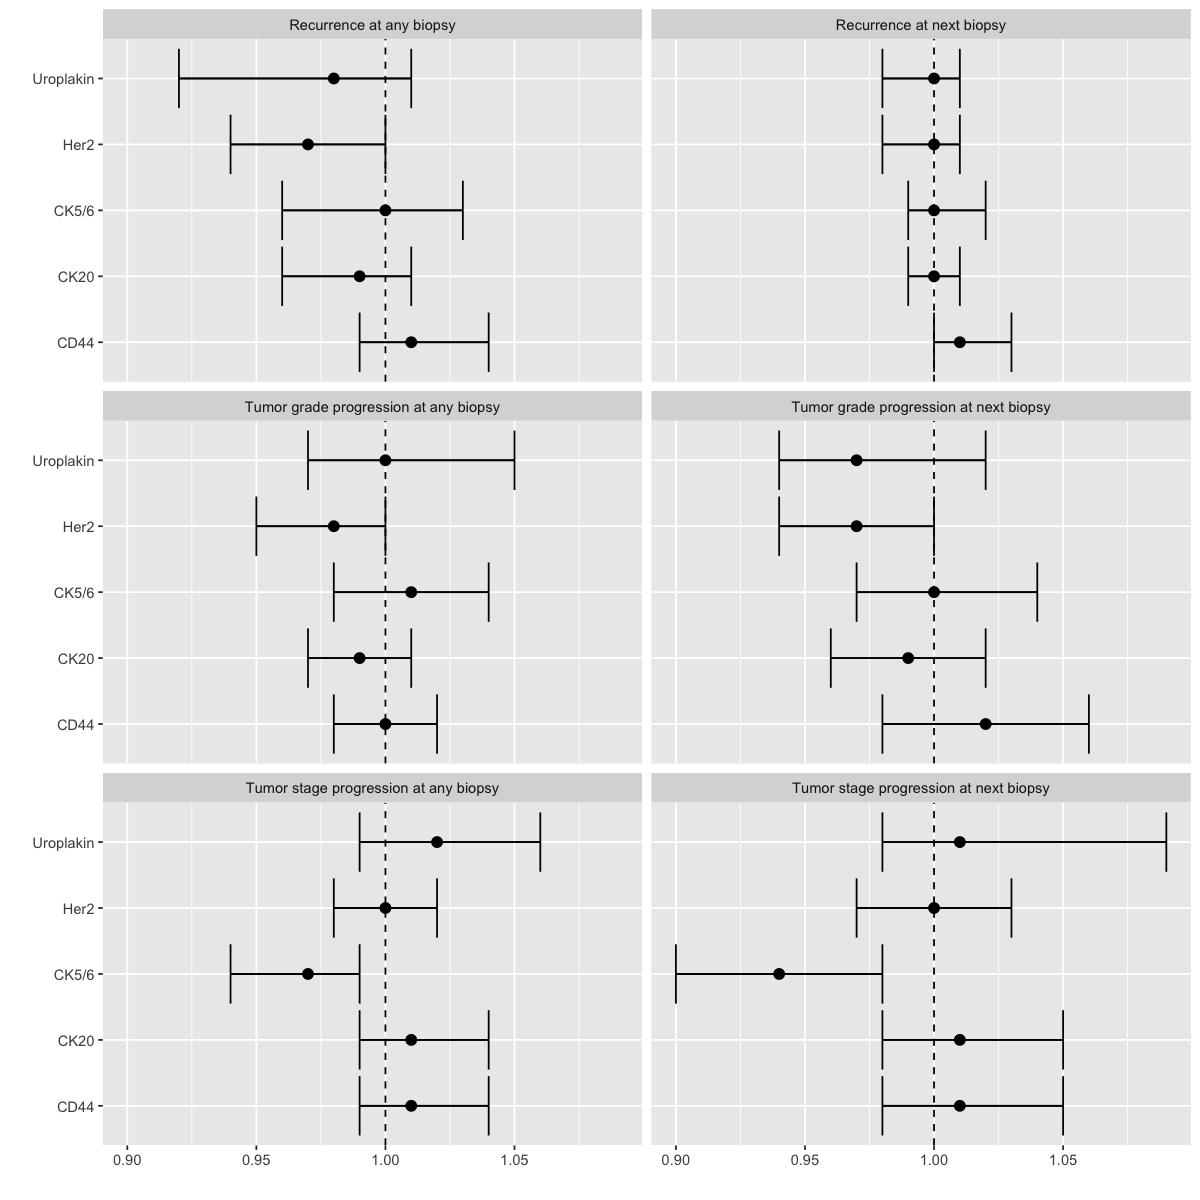

In [102]:
options(repr.plot.width = 10, repr.plot.height = 10)

g <- ggplot(outcome_marker, aes(x = marker, y = or, ymin = conf.low, ymax = conf.high)) +
    geom_pointrange() +
    geom_errorbar(aes(ymin = conf.low, ymax = conf.high)) +
    geom_hline(yintercept = 1, linetype = 2) +
    facet_wrap(~ outcome, ncol = 2) +
    coord_flip() +
    labs(x = "", y = "")

OR_plot <- gridExtra::grid.arrange(
    g,
    ncol = 1
)

In [103]:
ggsave(
  filename = "Figs/BL-NMIBUC-OR.png",
  plot = OR_plot,
  width = 10,
  height = 10,
  units = "in"
)